# A. Data import
### 1. Import the dataset into a DataFrame.

In [23]:
import pandas as pd
df = pd.read_csv("adult.csv")

### 2. In a pie chart, display the class distribution (percentage of people in the dataset with
### income <=50 K versus income>50K)

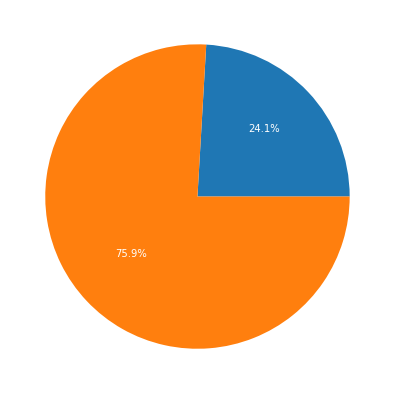

In [36]:

# Import libraries
import numpy as np
import matplotlib.pyplot as plt


 
data = [sum(df['Income'] == ' >50K'), sum(df['Income'] == ' <=50K')]
labels = ['>50K', '<=50K']
 
def func(value, allvalues):
    absolute = int(value / 100.*np.sum(allvalues))
    return "{:.1f}%\n".format(value, absolute)

fig, ax = plt.subplots(figsize =(10, 7))
ax.pie(data, autopct = lambda value: func(value, data), labels = labels, textprops = dict(color ="white"))
 
plt.show()

### 3. Check whether we have missing values. What is the percentage of rows with missing
### data?

In [100]:
missingDataRows = sum(df.isin([' ?']).any(axis=1)) # check if ' ?' null value exists in any of the columns (axis 1)
print("{:.2f}%".format(missingDataRows/len(df['Income']) * 100))


ValueError: No axis named 2 for object type DataFrame

# B. Data preprocessing (3 pts)
### 1. For each feature, replace missing values with the mode (categorical features) or the
### mean (numerical features).

### 2. Plot a box plot for each numerical feature by splitting on the label (<=50K and >50K).
### Can you spot any outliers?


### 3. Normalize numerical features. State which normalization method you chose.


### 4. Split your dataset into 80% training and 20% testing.


### 5. Transform categorical data into numerical using one-hot encoding.


### 6. Use LabelEncoder from sklearn.preprocessing to deal with the non-numerical
### output. 

# C. Modeling – Shallow Models (8 pts)
### 1. Decision tree
#### a. Split the 80% of your data into training and validation (choice of split percentage is left to you)


#### b. Train a decision tree classifier

#### c. Fine-tune your classifier on different hyperparameters on the validation set


#### d. Report the best hyper-parameters and the highest performance on the validation set


### 2. Logistic regression
#### a. On the full 80% data, train a linear regression model


#### b. Finetune your model through a 5-fold cross validation

# D. Modeling – Neural Networks (4 pts)
### a. On the full 80% data, for 200 epochs, train a neural network with 5-fold cross validation


### b. Plot the training and validation error per epoch


### c. BONUS: implement an early stopping criterion using callbacks

# E. Testing (3 pts)
### a. Based on the validation error, which model is the best?

### b. Report the performance metrics (accuracy, f-measure, precision, recall) on testing data


### c. Compute the percentage of women with prediction of income >=50k in the testing set?


### d. Compute the percentage of men with prediction of income >=50k in the testing set?


### e. Comment on the fairness of your model 